In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, BatchNormalization, Dropout
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

%matplotlib inline
%load_ext pycodestyle_magic

Using TensorFlow backend.


In [6]:
v1 = pd.read_csv('../weather_data/v1_obfs.csv')

In [7]:
v = [v1]
v_names = ['v1']
sel_columns = [' Meas_11', ' Meas_21']

### Functions

In [8]:
def sliding_window_2d(data, train_size, test_size, step_size):
    '''sliding window with an intersection between windows
    by size of _step_size_'''
    xy = []
    line_size = data.shape[1]
    for row in range(0, data.shape[0]):
        for start in range(0, line_size, step_size):
            stop =  start+train_size+test_size
            if stop <= line_size:
                xy.append(data[row, start: stop])
    return np.array(xy)


def xy_split(data, train_size):
    """split sliding windows into X and Y,
       input and output of the model.
    """
    x, y = data[:, :train_size], data[:, train_size:]
    return x, y


def norm_ts(data, transpose=True):
    """
    scaler ->  TS∈[0,1] .
    """
    scaler = MinMaxScaler(copy=True)
    if transpose:
        scaled01 = scaler.fit_transform(data.T).T
    else:
        scaled01 = scaler.fit_transform(data)
    return np.squeeze(scaled01), scaler


def inverse_norm(data, scaler):
    """ inverse scaling
    """
    return scaler.inverse_transform(data)


def train_test_reshape(train_x, test_x):
    """reshape + split train test 50-50"""
    return np.expand_dims(train_x, axis=2), np.expand_dims(test_x, axis=2)


def naive_prediction_mae(x_test, y_test):
    """prediction using last value"""
    naive_pred = 0
    n = x_test.shape[0]
    for i in range(n): 
        naive_pred += np.mean(np.abs(x_test[i, -1] - y_test[i, :]))
    naive_pred /= n
    print ('naive model = {0:0.4f}'.format(naive_pred))
    return None


def model_mae(model, x_test, y_test, scaler, inv_norm=False):
    """calculation MAE for prediction"""
    y_pred = model.predict(x_test)
    if inv_norm:
        y_pred=inverse_norm(y_pred.T, scaler).T
    mae = 0
    n = x_test.shape[0]
    for i in range(n): 
        mae += np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
    mae /= n
    print ('current model = {0:0.4f}'.format(mae))
    return None

def model_mae_n(model, x_test, y_test, scaler, n, inv_norm=False):
    """calculation MAE for prediction"""
    y_pred = model.predict(x_test)
    if inv_norm:
        y_pred=inverse_norm(y_pred.T, scaler).T
    mae = 0
    for i in range(n): 
        mae += np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
    mae /= n
    print ('current model = {0:0.4f}'.format(mae))
    return None

def model_mae_2_naive(model, x_test, x_test_original, y_test, scaler, inv_norm=False):
    """calculation MAE/naive ratio for prediction"""
    y_pred = model.predict(x_test)
    if inv_norm:
        y_pred=inverse_norm(y_pred.T, scaler).T
    mae_2_naive = 0
    n = x_test.shape[0]
    for i in range(n): 
        mae = np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
        naive = np.mean(np.abs(x_test_original[i, -1] - y_test[i, :]))
        if naive == 0:
            print (check_constant(y_test[i, :]), y_test[i,:])
        mae_2_naive += mae / naive
    mae_2_naive /= n
    print ('current model / naive = {0:0.4f}'.format(mae_2_naive))
    return None

### Let's plot selected columns

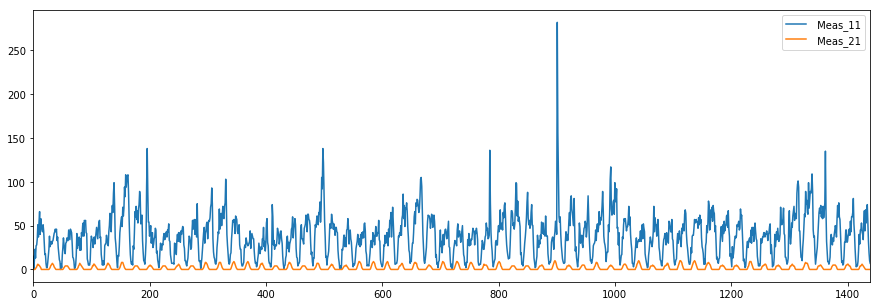

In [9]:
v1[sel_columns][:1440].plot(figsize=(15,5));

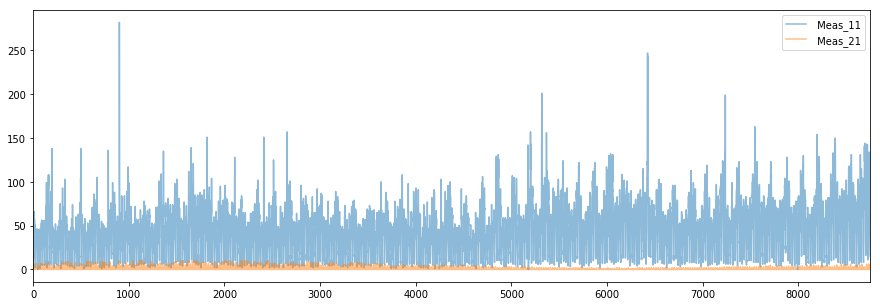

In [10]:
v1[sel_columns].plot(figsize=(15,5), alpha=.5);

### Parameters of Sliding Window

In [11]:
train_size = 168
test_size = 24
train_test_size = train_size + test_size
line_size = v1.shape[1]
step_size = 1
train_vs_test = .75
train_test_split = int(train_vs_test * v1.shape[0])

### Normalization

In [12]:
data= v1[sel_columns].values.T

train_xy = data[:, :train_test_split]

test_xy = data[:, train_test_split:]

train_xy_normed, scaler = norm_ts(train_xy)


train_xy = sliding_window_2d(data=train_xy_normed,
                             train_size=train_size,
                             test_size=test_size,
                             step_size=step_size)


test_xy = sliding_window_2d(data=test_xy,
                            train_size=train_size,
                            test_size=test_size,
                            step_size=step_size)

test_x_original, test_y_original = xy_split(test_xy, train_size)
test_x, scaler_test = norm_ts(test_x_original, transpose=True)


train_x, train_y = xy_split(train_xy, train_size)
train_x, test_x = train_test_reshape(train_x, test_x)

print (train_x.shape, test_x.shape, test_x_original.shape, test_y_original.shape)

(12746, 168, 1) (3996, 168, 1) (3996, 168) (3996, 24)


### CNN network

In [13]:

def cnn_model(x_train, y_train, batch_size, epochs=50, n_steps_for_train=train_size):
    
    
    input_dim = n_steps_for_train
    model = Sequential()
    model.add(Convolution1D(filters=6, kernel_size=4, input_shape=(input_dim ,1)))
    model.add(Flatten())
    model.add(Dense(units=64, kernel_initializer='normal'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(units=60, actiivation='relu'))
    # model.add(Dense(units=40, activation='relu'))
    model.add(Dense(units=24, activation='linear'))


    sgd = optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error',
                  optimizer='sgd',
                  metrics=['mae'])

    history = model.fit(x_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_split=.3, verbose=2)
    return model, history

In [14]:
model, history = cnn_model(x_train=train_x, y_train=train_y, batch_size=4, epochs=20)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 8922 samples, validate on 3824 samples
Epoch 1/20
 - 2s - loss: 0.0230 - mean_absolute_error: 0.1015 - val_loss: 0.0134 - val_mean_absolute_error: 0.0947
Epoch 2/20
 - 2s - loss: 0.0103 - mean_absolute_error: 0.0711 - val_loss: 0.0093 - val_mean_absolute_error: 0.0791
Epoch 3/20
 - 2s - loss: 0.0079 - mean_absolute_error: 0.0631 - val_loss: 0.0077 - val_mean_absolute_error: 0.0714
Epoch 4/20
 - 2s - loss: 0.0070 - mean_absolute_error: 0.0592 - val_loss: 0.0068 - val_mean_absolute_error: 0.0671
Epoch 5/20
 - 2s - loss: 0.0064 - mean_absolute_error: 0.0567 - val_loss: 0.0064 - val_mean_absolute_error: 0.0650
Epoch 6/20
 - 2s - loss: 0.0061 - mean_absolute_error: 0.0548 - val_loss: 0.0060 - val_mean_absolute_error: 0.0632
Epoch 7/20
 - 2s - loss: 0.0058 - mean_absolute_error: 0.0533 - val_loss: 0.0055 - val_mean_absolute_error: 0.0597
Epoch 8/20
 - 2s - loss: 0.

### Comparison to Naive model

In [16]:
naive_prediction_mae(x_test=test_x_original, y_test=test_y_original)
model_mae(model, x_test=test_x, y_test=test_y_original,
          scaler=scaler_test, inv_norm=True)
model_mae_2_naive(model,
                  x_test=test_x,
                  x_test_original=test_x_original,
                  y_test = test_y_original,
                  scaler=scaler_test,
                  inv_norm=True)


naive model = 16.0755
current model = 7.8361
current model / naive = 0.4750


In [ ]:
plt.rcParams.update({'figure.max_open_warning': 50})
np.random.seed(seed=123)
pred = model.predict(test_x)
pred = inverse_norm(pred.T, scaler=scaler_test).T
for i in np.random.randint(0, test_x.shape[0], 50):
    plt.figure()
    plt.plot(range(train_size), test_x_original[i], label='input')
    plt.plot(range(train_size, train_size+test_size), test_y_original[i], label='true')
    plt.plot(range(train_size, train_size+test_size), pred[i], c='m', label='prediction')
    plt.title(f'test {i}')
    plt.legend()

### Comparison on V11 and V21 separetly
#### V11:

In [25]:
import pickle
with open('../weather_data/v1-col-11.pkl', 'rb') as handle:
    benchmark = pickle.load(handle)


model_mae(model,
          x_test=benchmark['test_x'], 
          y_test=benchmark['test_y_original'],
          scaler=benchmark['scaler_benchmark'],
          inv_norm=True)

model_mae_2_naive(model, 
                  x_test=benchmark['test_x'], 
                  x_test_original=benchmark['test_x_original'], 
                  y_test=benchmark['test_y_original'], 
                  scaler=benchmark['scaler_benchmark'], 
                  inv_norm=True)


current model = 15.3353
current model / naive = 0.5299


#### Previos resuts, When trained just on V11:
```
current model = 24.1911
current model / naive = 0.8412
```

#### V21:

In [26]:
import pickle
with open('../weather_data/v1-col-21.pkl', 'rb') as handle:
    benchmark = pickle.load(handle)


model_mae(model,
          x_test=benchmark['test_x'], 
          y_test=benchmark['test_y_original'],
          scaler=benchmark['scaler_benchmark'],
          inv_norm=True)

model_mae_2_naive(model, 
                  x_test=benchmark['test_x'], 
                  x_test_original=benchmark['test_x_original'], 
                  y_test=benchmark['test_y_original'], 
                  scaler=benchmark['scaler_benchmark'], 
                  inv_norm=True)


current model = 0.3369
current model / naive = 0.4201


### The results when we train only on 1 column:

```
current model = 0.3272
current model / naive = 0.4112
```

In [110]:
(721-642)/642

0.12305295950155763